# Forecasting with Exogenous Regressors

This notebook provides examples of the accepted data structures for passing the expected value of exogenous variables when these are included in the mean.  For example, consider an AR(1) with 2 exogenous variables. The mean dynamics are

$$ Y_t = \phi_0 + \phi_1 Y_{t-1} + \beta_0 X_{0,t} + \beta_1 X_{1,t} + \epsilon_t. $$

The $h$-step forecast, $E_{T}[Y_{t+h}]$, depends on the conditional expectation of $X_{0,T+h}$ and $X_{1,T+h}$,

$$ E_{T}[Y_{T+h}] = \phi_0 + \phi_1 E_{T}[Y_{T+h-1}] + \beta_0 E_{T}[X_{0,T+h}] +\beta_1 E_{T}[X_{1,T+h}] $$

where $E_{T}[Y_{T+h-1}]$ has been recursively computed.

In order to construct forecasts up to some horizon $h$, it is necessary to pass $2\times h$ values ($h$ for each series).  If using the features of `forecast` that allow many forecast to be specified, it necessary to supply $n \times 2 \times h$ values.

There are two general purpose data structures that can be used for any number of exogenous variables and any number steps ahead:

* `dict` - The values can be pass using a `dict` where the keys are the variable names and the values are 2-dimensional arrays. This is the most natural generalization of a pandas `DataFrame` to 3-dimensions.
* `array` - The vales can alternatively be passed as a 3-d NumPy `array` where dimension 0 tracks the regressor index, dimension 1 is the time period and dimension 2 is the horizon.

When a model contains a single exogenous regressor it is possible to use a 2-d array or `DataFrame` where dim0 tracks the time period where the forecast is generated and dimension 1 tracks the horizon.

In the special case where a model contains a single regressor _and_ the horizon is 1, then a 1-d array or pandas Series can be used.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

## Simulating data

Two $X$ variables are simulated and are assumed to follow independent AR(1) processes. The data is then assumed to follow an ARX(1) with 2 exogenous regressors and GARCH(1,1) errors.

In [2]:
from arch.univariate import ARX, GARCH, ZeroMean, arch_model

burn = 250

x_mod = ARX(None, lags=1)
x0 = x_mod.simulate([1, 0.8, 1], nobs=1000 + burn).data
x1 = x_mod.simulate([2.5, 0.5, 1], nobs=1000 + burn).data

resid_mod = ZeroMean(volatility=GARCH())
resids = resid_mod.simulate([0.1, 0.1, 0.8], nobs=1000 + burn).data

phi1 = 0.7
phi0 = 3
y = 10 + resids.copy()
for i in range(1, y.shape[0]):
    y[i] = phi0 + phi1 * y[i - 1] + 2 * x0[i] - 2 * x1[i] + resids[i]

x0 = x0.iloc[-1000:]
x1 = x1.iloc[-1000:]
y = y.iloc[-1000:]
y.index = x0.index = x1.index = np.arange(1000)

## Plotting the data

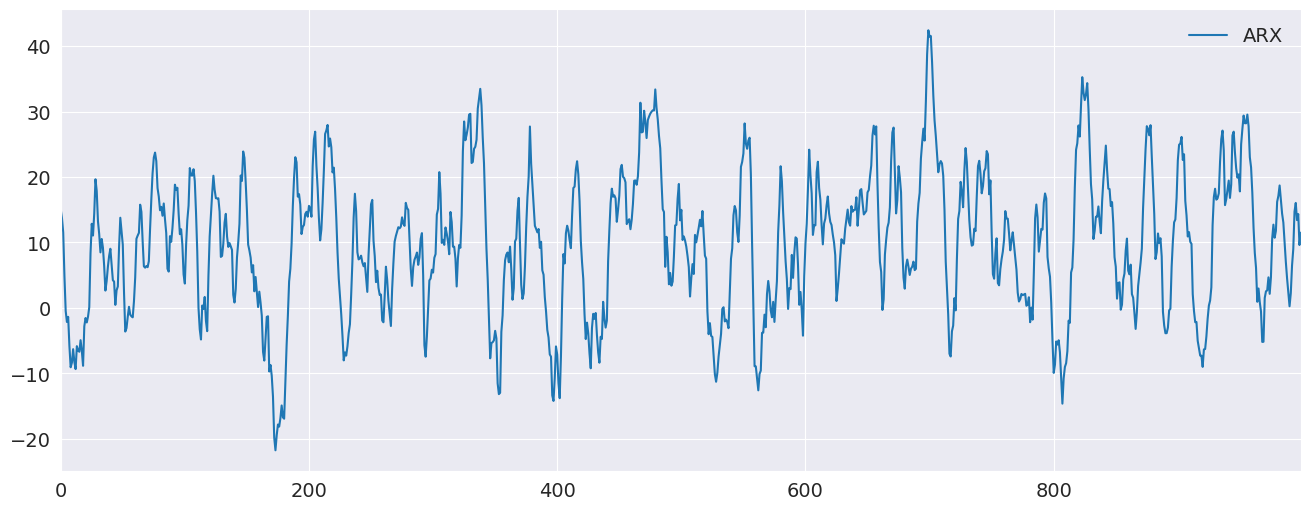

In [3]:
ax = pd.DataFrame({"ARX": y}).plot(legend=False)
ax.legend(frameon=False)
_ = ax.set_xlim(0, 999)

## Forecasting the X values

The forecasts of $Y$ depend on forecasts of $X_0$ and $X_1$.  Both of these follow simple AR(1), and so we can construct the forecasts for all time horizons.  Note that the value in position `[i,j]` is the time-`i` forecast for horizon `j+1`.

In [4]:
x0_oos = np.empty((1000, 10))
x1_oos = np.empty((1000, 10))
for i in range(10):
    if i == 0:
        last = x0
    else:
        last = x0_oos[:, i - 1]
    x0_oos[:, i] = 1 + 0.8 * last
    if i == 0:
        last = x1
    else:
        last = x1_oos[:, i - 1]
    x1_oos[:, i] = 2.5 + 0.5 * last

x1_oos[-1]

array([4.27038511, 4.63519255, 4.81759628, 4.90879814, 4.95439907,
       4.97719953, 4.98859977, 4.99429988, 4.99714994, 4.99857497])

## Fitting the model

Next, the model is fit. The parameters are precisely estimated.

In [5]:
exog = pd.DataFrame({"x0": x0, "x1": x1})
mod = arch_model(y, x=exog, mean="ARX", lags=1)
res = mod.fit(disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                   data   R-squared:                       0.990
Mean Model:                      AR-X   Adj. R-squared:                  0.990
Vol Model:                      GARCH   Log-Likelihood:               -1417.51
Distribution:                  Normal   AIC:                           2849.02
Method:            Maximum Likelihood   BIC:                           2883.36
                                        No. Observations:                  999
Date:                Fri, Oct 17 2025   Df Residuals:                      995
Time:                        09:21:39   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          3.0122      0.168     17.972  3.207e-72 [  2.684,  3.34

## Using a `dict`

The first approach uses a dict to pass the two variables. The key consideration here is the the keys of the dictionary must **exactly** match the variable names (`x0` and `x1` here).  The dictionary here contains only the final row of the forecast values since `forecast` will only make forecasts beginning from the final in-sample observation by default.

### Using `DataFrame`

While these examples make use of NumPy arrays, these can be `DataFrames`. This allows the index to be used to track the forecast origination point, which can be a helpful device.

<Axes: >

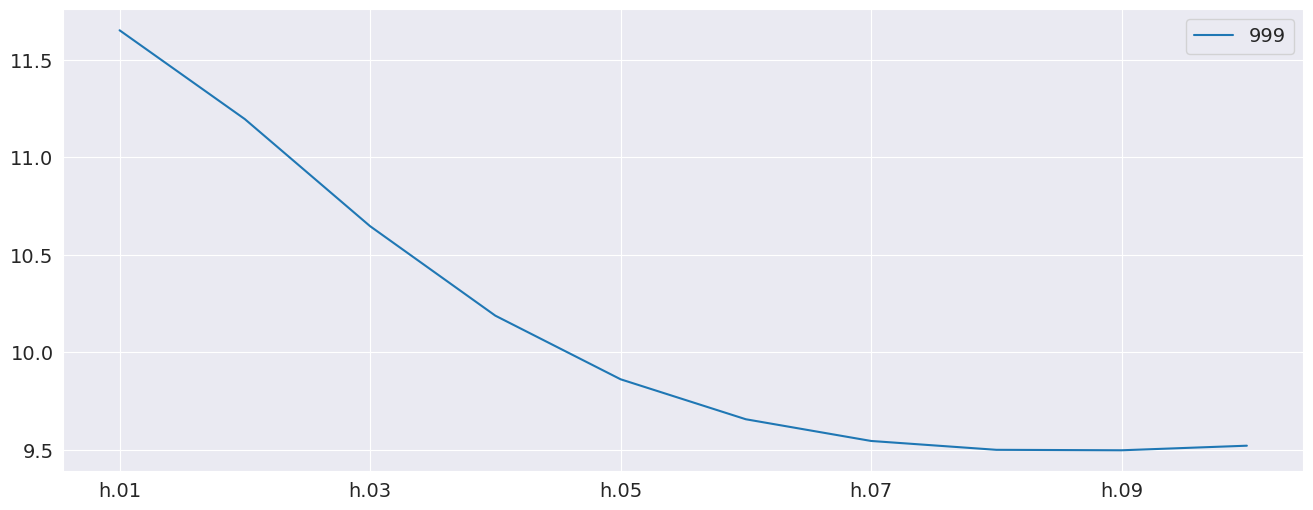

In [6]:
exog_fcast = {"x0": x0_oos[-1:], "x1": x1_oos[-1:]}
forecasts = res.forecast(horizon=10, x=exog_fcast)
forecasts.mean.T.plot()

## Using an `array`

An array can alternatively be used.  This frees the restriction on matching the variable names although the order must match instead. The forecast values are 2 (variables) by 1 (forecast) by 10 (horizon).

In [7]:
exog_fcast = np.array([x0_oos[-1:], x1_oos[-1:]])
print(f"The shape is {exog_fcast.shape}")
array_forecasts = res.forecast(horizon=10, x=exog_fcast)
print(array_forecasts.mean - forecasts.mean)

The shape is (2, 1, 10)
     h.01  h.02  h.03  h.04  h.05  h.06  h.07  h.08  h.09  h.10
999   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0


## Producing multiple forecasts

`forecast` can produce multiple forecasts using the same fit model.  Here the model is fit to the first 500 observations and then forecasting for the remaining values are produced. It must be the case that the `x` values passed for `forecast` have the same number of rows as the table of forecasts produced.


In [8]:
res = mod.fit(disp="off", last_obs=500)
exog_fcast = {"x0": x0_oos[-500:], "x1": x1_oos[-500:]}
multi_forecasts = res.forecast(start=500, horizon=10, x=exog_fcast)
multi_forecasts.mean.tail(10)

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
990,0.381679,1.343585,2.558234,3.762348,4.848657,5.783941,6.568566,7.216739,7.747091,8.178372
991,3.403698,4.382443,5.238717,5.988977,6.641641,7.203753,7.682972,8.087724,8.426802,8.708881
992,9.138940,10.610254,11.355877,11.668667,11.729895,11.651679,11.502834,11.324900,11.142221,10.968352
993,11.066246,12.266016,12.850156,13.027083,12.952322,12.735050,12.448308,12.138740,11.834556,11.551541
994,15.889265,15.792532,15.189434,14.438420,13.699403,13.036356,12.468108,11.993291,11.602418,11.283578
995,15.447326,14.660544,13.875230,13.169301,12.565904,12.063988,11.652945,11.319416,11.050290,10.833866
996,11.574122,10.389810,9.674316,9.278937,9.093470,9.039865,9.064720,9.132586,9.220658,9.314792
997,13.670438,12.955218,12.315467,11.786575,11.366495,11.039975,10.789099,10.597429,10.451285,10.339823
998,8.602134,8.339108,8.399034,8.581313,8.793726,8.996551,9.174978,9.325611,9.449929,9.551196
999,11.642755,11.181477,10.631496,10.175723,9.855005,9.656297,9.551169,9.511257,9.513399,9.540453


The plot of the final 5 forecast paths shows the the mean reversion of the process.

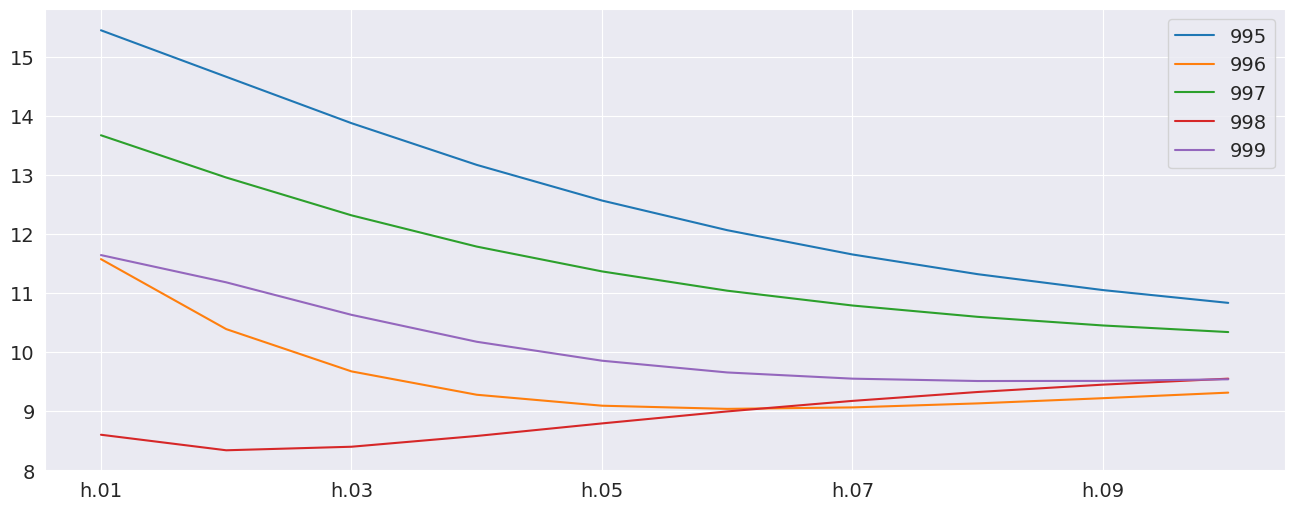

In [9]:
_ = multi_forecasts.mean.tail().T.plot()

The previous example made use of dictionaries where each of the values was a 500 (number of forecasts) by 10 (horizon) array.  The alternative format can be used where `x` is a 3-d array with shape 2 (variables) by 500 (forecasts) by 10 (horizon).

In [10]:
exog_fcast = np.array([x0_oos[-500:], x1_oos[-500:]])
print(exog_fcast.shape)
array_multi_forecasts = res.forecast(start=500, horizon=10, x=exog_fcast)
np.max(np.abs(array_multi_forecasts.mean - multi_forecasts.mean))

(2, 500, 10)


np.float64(0.0)

## `x` input array sizes

While the natural shape of the `x` data is the number of forecasts, it is also possible to pass an `x` that has the same shape as the `y` used to construct the model.  The may simplify tracking the origin points of the forecast.  Values are are not needed are ignored. In this example, the out-of-sample values are 2 by 1000 (original number of observations) by 10.  Only the final 500 are used. 

<div class="alert alert-warning">
    <h3><b>WARNING</b></h3>
    Other sizes are <b>not</b> allowed. The size of the out-of-sample data must either match the original data size or the number of forecasts.
</div>

In [11]:
exog_fcast = np.array([x0_oos, x1_oos])
print(exog_fcast.shape)
array_multi_forecasts = res.forecast(start=500, horizon=10, x=exog_fcast)
np.max(np.abs(array_multi_forecasts.mean - multi_forecasts.mean))

(2, 1000, 10)


np.float64(0.0)

## Special Cases with a single `x` variable

When a model consists of a single exogenous regressor, then `x` can be a 1-d or 2-d array (or `Series` or `DataFrame`).

In [12]:
mod = arch_model(y, x=exog.iloc[:, :1], mean="ARX", lags=1)
res = mod.fit(disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                   data   R-squared:                       0.946
Mean Model:                      AR-X   Adj. R-squared:                  0.946
Vol Model:                      GARCH   Log-Likelihood:               -2310.79
Distribution:                  Normal   AIC:                           4633.59
Method:            Maximum Likelihood   BIC:                           4663.03
                                        No. Observations:                  999
Date:                Fri, Oct 17 2025   Df Residuals:                      996
Time:                        09:21:40   Df Model:                            3
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         -6.9018      0.287    -24.058 6.886e-128 [ -7.464, -6.33

These two examples show that both formats can be used.

In [13]:
forecast_1d = res.forecast(horizon=10, x=x0_oos[-1])
forecast_2d = res.forecast(horizon=10, x=x0_oos[-1:])
print(forecast_1d.mean - forecast_2d.mean)

## Simulation-forecasting

mod = arch_model(y, x=exog, mean="ARX", lags=1, power=1.0)
res = mod.fit(disp="off")

     h.01  h.02  h.03  h.04  h.05  h.06  h.07  h.08  h.09  h.10
999   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0


## Simulation

`forecast` supports simulating paths. When forecasting a model with exogenous variables, the same value is used to in all mean paths.  If you wish to also simulate the paths of the `x` variables, these need to generated and then passed inside a loop. 

### Static out-of-sample `x`
This first example shows that variance of the paths when the same `x` values are used in the forecast. There is a sense the out-of-sample `x` are treated as deterministic.

In [14]:
x = {"x0": x0_oos[-1], "x1": x1_oos[-1]}
sim_fixedx = res.forecast(horizon=10, x=x, method="simulation", simulations=100)
sim_fixedx.simulations.values.std(1)

array([[0.81639476, 1.01950907, 1.15889758, 1.33660157, 1.19925629,
        1.08094337, 1.18610117, 1.21063891, 1.19408991, 1.14519139]])

### Simulating the out-of-sample `x`

This example simulates distinct paths for the two exogenous variables and then simulates a single path.  This is then repeated 100 times.  We see that variance is much higher when we account for variation in the x data.

In [15]:
from numpy.random import RandomState


def sim_ar1(params: np.ndarray, initial: float, horizon: int, rng: RandomState):
    out = np.zeros(horizon)
    shocks = rng.standard_normal(horizon)
    out[0] = params[0] + params[1] * initial + shocks[0]
    for i in range(1, horizon):
        out[i] = params[0] + params[1] * out[i - 1] + shocks[i]
    return out


simulations = []
rng = RandomState(20210301)
for _ in range(100):
    x0_sim = sim_ar1(np.array([1, 0.8]), x0.iloc[-1], 10, rng)
    x1_sim = sim_ar1(np.array([2.5, 0.5]), x1.iloc[-1], 10, rng)
    x = {"x0": x0_sim, "x1": x1_sim}
    fcast = res.forecast(horizon=10, x=x, method="simulation", simulations=1)
    simulations.append(fcast.simulations.values)

Finally the standard deviation is quite a bit larger. This is a most accurate value fo the long-run variance of the forecast residuals which should account for dynamics in the model and any exogenous regressors.

In [16]:
joined = np.concatenate(simulations, 1)
joined.std(1)

array([[3.06234309, 4.76422832, 6.26310005, 7.43179816, 8.28692451,
        8.41338889, 8.57781725, 8.62990779, 8.82266996, 9.38831672]])

## Conditional Mean Alignment vs. Forecast Alignment

When fitting a model with exogenous variables, the data are aligned so that the values in ``x[j]`` are used to compute the conditional mean of ``y[j]``. For example, in the case of an AR(1)-X, the model is 

$$
Y_t = \phi_0 + \phi_1 Y_{t-1} + \beta X_{t} + \epsilon_t. 
$$

We can recover the conditional mean by subtracting the residuals from the original data. When we do this we see that the conditional mean of observation 0 is missing since we need one lag of $Y$ to fit the model.


In [17]:
mod = arch_model(y, x=exog, mean="ARX", lags=1)
res = mod.fit(disp="off")
y - res.resid

0            NaN
1      12.565761
2      14.157370
3       5.541897
4       1.613833
         ...    
995    15.147850
996    13.400900
997    13.499572
998    11.095365
999    11.580183
Length: 1000, dtype: float64

### Conditional Mean uses target alignment
When modeling the conditional mean in an AR-X, HAR-X, or LS model, the $X$ data is target-aligned.  This requires that when modeling the mean of ``y[t]``, the correct values of $X$ must appear in ``x[t]``. Mathematically, the $X$ matrix used when estimating a model should have the structure (using the Python indexing convention of a T-element data set having indices 0, 1, ..., T-1):

$$
\left[\begin{array}{c}
X_{0}\\
X_{1}\\
\vdots\\
X_{T-1}
\end{array}\right]
$$




### ``forecast`` uses origin alignment

Forecasting with $X$ values aligns them differently. When producing a 1-step-ahead forecast for $Y_{t+1}$ using information available at time $t$, the $X$ values used for this forecast must appear in for ``t``.  This is needed since when once wants to produce true out-of-sample forecasts (see below), it must be the case that the final row of ``x`` passed ``forecast`` must all occur after the final time stamp of the most recent $Y$ value. Mathematically, the $X$ matrix used in forecasting should have the following structure (using Python indexing convention so that a $T$ observation dataset will have indices 0, 1, ..., T-1).

$$
\left[\begin{array}{cccc}
E\left[X_{1}|\mathcal{F}_0\right] & E\left[X_{2}|\mathcal{F}_0\right] & \ldots & E\left[X_{h|\mathcal{F}_0}\right]\\
E\left[X_{2}|\mathcal{F}_1\right] & E\left[X_{3}|\mathcal{F}_0\right] & \ldots & E\left[X_{h+1}|\mathcal{F}_1\right]\\
\vdots & \vdots & \vdots & \vdots\\
E\left[X_{T}|\mathcal{F}_{T-1}\right] & E\left[X_{T+1}|\mathcal{F}_{T-1}\right] & \ldots & E\left[X_{T+h-1}|\mathcal{F}_{T-1}\right]
\end{array}\right]
$$

where $|\mathcal{F}_{s}$ is the time-$s$ information set.

If you use the same ``x`` value in the model when forecasting, you will see different values due to this alignment difference. Naively using the same ``x`` values ie equivalent to setting

$$ E\left[X_{s}|\mathcal{F}_{s-1} \right] = X_{s-1} $$

In general this would not be correct when forecasting, and will always produce forecasts that differ from the conditional mean.  In order to recover the conditional mean using the forecast function, it is necessary to ``shift`` the $X$ values by -1, so that once shifted, the ``x`` values will have the relationship

$$ E\left[X_{s}|\mathcal{F}_{s-1} \right] = X_{s} .$$

Here we shift the $X$ data by ``-1`` so ``x[s]`` is treated as being in the information set for ``y[s-1]``. Also, note that the final forecast is ``NaN``. Conceptually this must be the case because the value of $X$ at 999 should be ahead of 999 (i.e., at observation 1,000), and we do not have this value. 

In [18]:
exog_dict = {col: exog[[col]].shift(-1) for col in exog}
fcast = res.forecast(horizon=1, x=exog_dict, start=0)
fcast.mean

,h.1
0,12.565761
1,14.157370
2,5.541897
3,1.613833
4,-3.299147
...,...
995,13.400900
996,13.499572
997,11.095365
998,11.580183


### (Nearly) out-of-sample forecasts

These "in-sample" forecasts are not really forecasts at all but are just fitted values with a different alignment. If you want real (nearly) out-of-sample forecasts$\dagger$, it is necessary to replace the actual values of $X$ with their conditional expectation. This can be done by taking the fitted values from AR(1) models of the $X$ variables. 

$\dagger$ These are not true out-of-sample since the parameters were estimated using data from that same range of indices where these forecasts target. True out-of-sample requires both using forecast $X$ values and parameters estimated without the period being forecasted.

In [19]:
res0 = ARX(exog["x0"], lags=1).fit()
res1 = ARX(exog["x1"], lags=1).fit()
forecast_x = pd.concat(
    [res0.forecast(start=0).mean, res1.forecast(start=0).mean], axis=1
)
forecast_x.columns = ["x0f", "x1f"]
in_samp_forcast_exog = {"x0": forecast_x[["x0f"]], "x1": forecast_x[["x1f"]].shift(-1)}
fcast = res.forecast(horizon=1, x=in_samp_forcast_exog, start=0)
fcast.mean

,h.1
0,13.165640
1,13.971410
2,10.306367
3,2.111583
4,-0.566754
...,...
995,15.307788
996,11.743475
997,12.610898
998,10.735460


### True out-of-sample forecasts

In order to make a true out-of-sample prediction, we need the expected values of ``X`` from the end of the data we have. These can be constructed by forecasting the two $X$ variables and then passing these values as ``x`` to ``forecast``.

In [20]:
mod = arch_model(y, x=exog, mean="ARX", lags=1)
res = mod.fit(disp="off")

actual_x_oos = {
    "x0": res0.forecast(horizon=10).mean,
    "x1": res1.forecast(horizon=10).mean,
}
fcasts = res.forecast(horizon=10, x=actual_x_oos)
fcasts.mean

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
999,11.603781,11.093793,10.494295,9.992527,9.631695,9.399934,9.269134,9.210627,9.200539,9.220795
